# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))
import matplotlib.pyplot as plt

In [2]:
from pkg.marker_config import *
init_kinect()
cameraMatrix, distCoeffs = get_calibration()
aruco_map, dictionary = get_aruco_config()

Device configuration: 
	color_format: 3 
	(0:JPG, 1:NV12, 2:YUY2, 3:BGRA32)

	color_resolution: 5 
	(0:OFF, 1:720p, 2:1080p, 3:1440p, 4:1536p, 5:2160p, 6:3072p)

	depth_mode: 3 
	(0:OFF, 1:NFOV_2X2BINNED, 2:NFOV_UNBINNED,3:WFOV_2X2BINNED, 4:WFOV_UNBINNED, 5:Passive IR)

	camera_fps: 2 
	(0:5 FPS, 1:15 FPS, 2:30 FPS)

	synchronized_images_only: False 
	(True of False). Drop images if the color and depth are not synchronized

	depth_delay_off_color_usec: 0 ms. 
	Delay between the color image and the depth image

	wired_sync_mode: 0
	(0:Standalone mode, 1:Master mode, 2:Subordinate mode)

	subordinate_delay_off_master_usec: 0 ms.
	The external synchronization timing.

	disable_streaming_indicator: False 
	(True or False). Streaming indicator automatically turns on when the color or depth camera's are in use.




In [3]:
while True:
    try:
        color_image = get_kinect_image()
        objectPose_dict, corner_dict = get_object_pose_dict(color_image, aruco_map, dictionary, cameraMatrix, distCoeffs)
        color_image_out = draw_objects(color_image, aruco_map, objectPose_dict, corner_dict, cameraMatrix, distCoeffs, axis_len=0.1)
        xyz_indy0, rpy_indy0 = T2xyzrpy(get_T_rel('floor', 'indy0', objectPose_dict))
        xyz_panda1, rpy_panda1 = T2xyzrpy(get_T_rel('floor', 'panda1', objectPose_dict))
        T_bc = SE3_inv(objectPose_dict['floor'])
        T_bo_0 = get_T_rel('floor', 'box1', objectPose_dict)
        xyz_cam, rvec_cam = T2xyzrvec(T_bc)
        xyz_box1, rvec_box1 = T2xyzrvec(T_bo_0)
        xyz_goal, rvec_goal = T2xyzrvec(get_T_rel('floor', 'goal', objectPose_dict))
        xyz_wall, rvec_wall = T2xyzrvec(get_T_rel('floor', 'wall', objectPose_dict))
        break
    except KeyError as e:
        print(e)
        break
    except Exception as e:
        print(e)
        pass

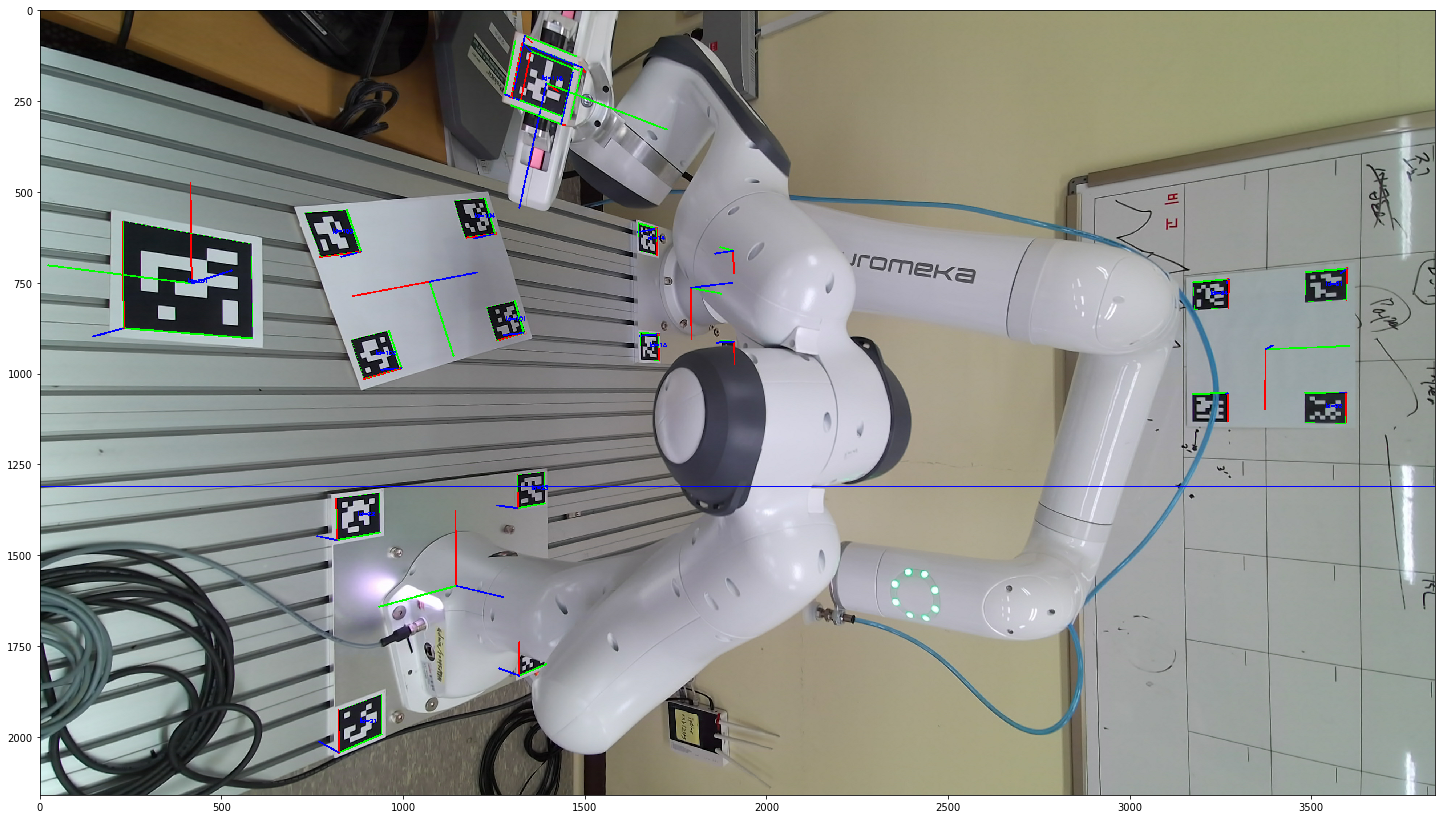

In [4]:
plt.figure(figsize=(25,15))
plt.imshow(color_image_out[:,:,[2,1,0]])

In [5]:
# disconnect_kinect()

In [6]:
urdf_content = None
from pkg.robots_custom import *
xcustom = XacroCustomizer()
xcustom.clear()
# xcustom.add_robot(RobotType.indy7_robot, xyz=[0,-0.5,0], rpy=[0,0,0])
# xcustom.add_robot(RobotType.panda_robot, xyz=[0,0.5,0], rpy=[0,0,0])
xcustom.add_robot(RobotType.indy7_robot, xyz=xyz_indy0, rpy=rpy_indy0)
xcustom.add_robot(RobotType.panda_robot, xyz=xyz_panda1, rpy=rpy_panda1)
xcustom.write_xacro()
vel_scale = 1.0/2.0
effort_scale = 1.0/2.0
JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, urdf_content = \
        xcustom.convert_xacro_to_urdf(
        joint_fix_dict={'finger':'upper'},
        vel_limit_dict={k: v*vel_scale for k,v in {
            'panda1_joint1': np.deg2rad(150),  'panda1_joint2': np.deg2rad(150), 
            'panda1_joint3': np.deg2rad(150), 'panda1_joint4': np.deg2rad(150), 
            'panda1_joint5': np.deg2rad(180), 'panda1_joint6': np.deg2rad(180), 'panda1_joint7': np.deg2rad(180), 
            'indy0_joint0': np.deg2rad(150), 'indy0_joint1': np.deg2rad(150), 'indy0_joint2': np.deg2rad(150), 
            'indy0_joint3': np.deg2rad(180), 'indy0_joint4': np.deg2rad(180), 'indy0_joint5': np.deg2rad(180), 
        }.items()},
        effort_limit_dict={k: v*effort_scale for k,v in {
            'panda1_joint1': np.deg2rad(360),  'panda1_joint2': np.deg2rad(360), 
            'panda1_joint3': np.deg2rad(360), 'panda1_joint4': np.deg2rad(360), 
            'panda1_joint5': np.deg2rad(360), 'panda1_joint6': np.deg2rad(360), 'panda1_joint7': np.deg2rad(360), 
            'indy0_joint0': np.deg2rad(360), 'indy0_joint1': np.deg2rad(360), 'indy0_joint2': np.deg2rad(360), 
            'indy0_joint3': np.deg2rad(360), 'indy0_joint4': np.deg2rad(360), 'indy0_joint5': np.deg2rad(360), 
        }.items()}
    )
ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                          0,-np.pi/8,0,-np.pi/2,0,np.pi/2,0])
refine_meshes()
xcustom.start_rviz()
    
from pkg.constraint_graph import *
from pkg.constants import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True
rospy.init_node('task_planner', anonymous=True)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [7]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content,
                       connect_panda = True, connect_indy = True)
col_items_dict = graph.set_fixed_geometry_items(
    get_geometry_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

Connect: Server IP (192.168.0.63)


# Custom Robots

In [8]:
gtimer.tic("set_scene")
collision=True
graph.add_geometry_items("world", 
                         [
                           GeoMesh(uri="package://my_mesh/meshes/stl/end_tool_asm_ctd.stl", BLH=(0.01,0.01,0.01), orientation_mat=Rot_axis(3,np.pi/16), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                   urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                           GeoBox(np.dot(Rot_axis(3,np.pi/16), (-0.055, 0,0.012)), (0.05,0.05,0.07), orientation=(0,0,np.pi/16), 
                                  name="gripper1_col", link_name="indy0_tcp", urdf_content=graph.urdf_content, color=(0,1,0,0.5), collision=collision),
                           GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(xyz_wall, (3,3,0.05),orientation=rvec_wall, name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                           GeoBox(np.subtract(xyz_cam, [0,0,xyz_cam[2]/2]), 
                                  (0.1,0.1,xyz_cam[2]), 
                                  name="cam_pole", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
#                            GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                           GeoBox(xyz_goal, (0.1,0.1,1e-3),orientation=rvec_goal, name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1), collision=False)],
                         fixed=True)

graph.add_geometry_items("world", 
                         [GeoBox(xyz_box1, (0.05,0.05,0.05),orientation=rvec_box1, name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision)],
                         fixed=False)

graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,11e-2], link_name="panda1_hand", direction=[0,1,0])
graph.register_binder(name='vac2', _type=VacuumTool, point=[-0.055,0,0.048], link_name="indy0_tcp", direction=[0,0,1])
graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
graph.register_binder(name='goal', _type=PlaceFrame, point=xyz_goal, orientation=rvec_goal, link_name="world")

box1_put_point = get_put_dir(Robj=Rotation.from_rotvec(rvec_box1).as_dcm(), dir_vec_dict=dir_vec_dict)+"_p"
graph.register_object('box1', _type=BoxAction, binding=(box1_put_point,"floor"), hexahedral=True)

graph.build_graph()
gtimer.toc("set_scene")
print("put_point: {}".format(box1_put_point))

put_point: right_p


# Set RVIZ

In [9]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=300, regularization_factor= 1e-6)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


In [10]:
if graph.connect_indy and graph.connect_panda:
    graph.show_pose(graph.get_real_robot_pose())
else:
    graph.show_pose(ZERO_JOINT_POSE)

# Calibration

## Sample configurations

In [11]:
graph.set_camera_config(aruco_map, dictionary, cameraMatrix, distCoeffs, corner_dict)

In [12]:
Teo_ref = SE3(Rot_zyx(-np.pi/2,np.pi/2,0), [0,0,0.091])

In [23]:
sample_list = []
image_list = []

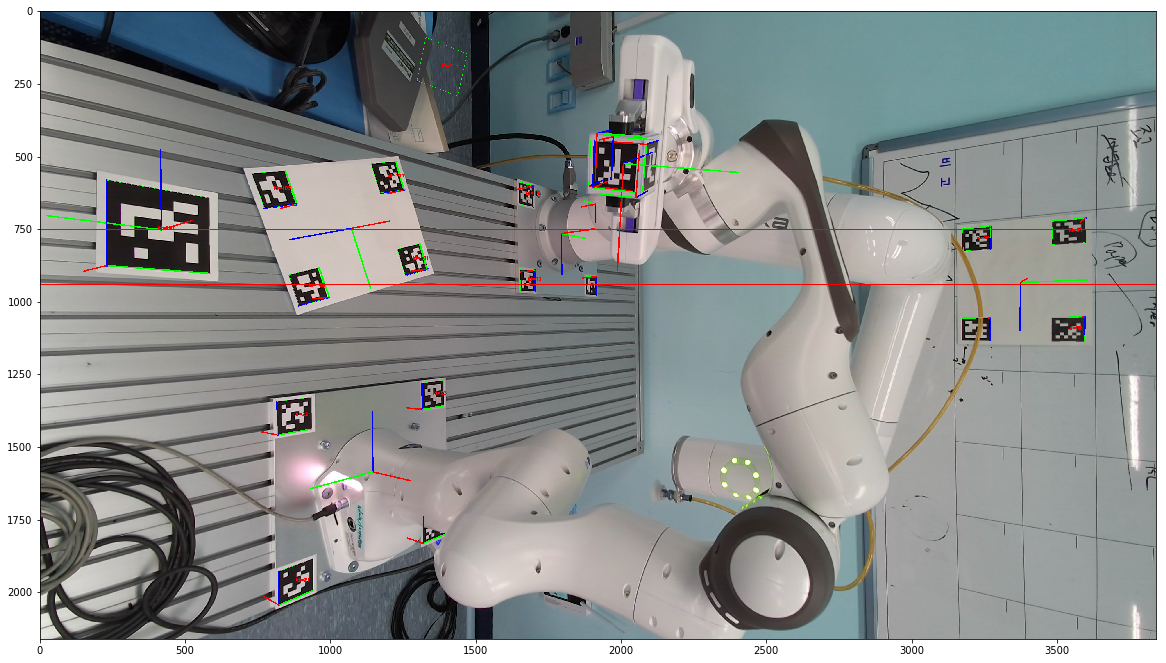

In [24]:
xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict = graph.sample_Trel('box1', 'panda1_hand', 'panda1_link0', 'panda1', Teo=Teo_ref)
color_image_out = graph.draw_objects_graph(color_image, objectPose_dict)
plt.figure(figsize=(20,18))
plt.imshow(color_image_out)

In [25]:
sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
image_list.append(color_image_out.copy())

## calibrate

In [16]:
from pkg.calibrator import *

In [27]:
set_RP_calib(sample_list)
T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))

0.002248047710155593

In [134]:
T_bbbr, T_reeo = calibrate_offset()

Compiling cost function...
Computing gradient of cost function...
 iter		   cost val	    grad. norm
    1	+1.1609282401648320e+01	7.95633528e+00
    2	+5.9714777907741068e+00	3.86462890e+00
    3	+5.4940300446667836e+00	5.96549950e+00
    4	+3.8392174174393801e+00	4.37826757e+00
    5	+2.6412741613466824e+00	3.19316227e+00
    6	+1.6829827932524795e+00	8.96547243e-01
    7	+1.5715671558219462e+00	6.28033975e-01
    8	+1.4935666799596194e+00	8.82520899e-01
    9	+1.4127304833090919e+00	8.60177414e-01
   10	+1.3474768882977493e+00	9.38858062e-01
   11	+1.2330751372355582e+00	5.58959874e-01
   12	+1.1673531757322217e+00	9.83534630e-01
   13	+1.0404051678928374e+00	5.00910759e-01
   14	+9.4118249181096048e-01	1.03132352e+00
   15	+8.2853846503201478e-01	8.04030115e-01
   16	+7.3519210417382563e-01	5.95595012e-01
   17	+6.6347706216425717e-01	7.23689986e-01
   18	+6.2476739777559875e-01	9.84173981e-01
   19	+5.1780199117077452e-01	4.55908212e-01
   20	+4.4762566450137220e-01	9.21803409e-01


In [18]:
# save_offset("panda")

In [19]:
T_bbbr, T_reeo, Teo_ref = load_offset("panda")

In [28]:
Xopt = (SE3_R(T_bbbr), SE3_P(T_bbbr), SE3_R(T_reeo), SE3_P(T_reeo))
T_err(Xopt)

0.0008191987154324842

In [62]:
graph.panda.move_finger(True)

True

In [61]:
graph.panda.move_finger(False)

False

# find_proper_offset

In [63]:
val_dict  = {}
for i_x in range(-2,2):
    for i_y in range(-2,2):
        for i_z in range(-2,2):
            sample_list = []
#             image_list = []
            
            xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict = sample_Trel(self, 'box1', 'panda1_hand', 'panda1_link0', 'panda1', 
                                                                                             Teo=SE3(Rot_zyx(np.pi/2*i_x,np.pi/2*i_y,np.pi/2*i_z), [0,0,0.091]))
#             color_image_out = draw_objects_graph(self, color_image, objectPose_dict)
#             plt.figure(figsize=(20,18))
#             plt.imshow(color_image_out)

            sample_list.append((xyz_cam, rvec_cam, xyz_cal, rvec_cal, color_image, objectPose_dict))
#             image_list.append(color_image_out.copy())

            Pcam_list = []
            Rcam_list = []
            Pcal_list = []
            Rcal_list = []

            for sample in sample_list:
                xyz_cam, rvec_cam, xyz_cal, rvec_cal, _, _ = sample
                Pcam_list.append(xyz_cam[0])
                Rcam_list.append(Rotation.from_rotvec(rvec_cam[0]).as_dcm())
                Pcal_list.append(xyz_cal[0])
                Rcal_list.append(Rotation.from_rotvec(rvec_cal[0]).as_dcm())

            Rcam_list = np.array(Rcam_list)
            Pcam_list = np.expand_dims(Pcam_list, axis=-1)
            Rcal_list = np.array(Rcal_list)
            Pcal_list = np.expand_dims(Pcal_list, axis=-1)
            Rcaminv_list = np.array([Rcam.transpose() for Rcam in Rcam_list])
            Pcaminv_list = np.array([-np.matmul(Rcaminv, Pcam) for Rcaminv, Pcam in zip(Rcaminv_list, Pcam_list)])

            N_POS = len(Pcaminv_list)
            CALIB_TIMEOUT = 5
            print("done: {}".format((i_x, i_y,i_z)))
            val_dict[(i_x, i_y,i_z)] = T_err((np.identity(3), (0,0,0), np.identity(3), (0,0,0)))
print("min error case: {}".format(sorted(val_dict.items(), key=lambda x: x[1])[0]))

done: (-2, -2, -2)
done: (-2, -2, -1)
done: (-2, -2, 0)
done: (-2, -2, 1)
done: (-2, -1, -2)
done: (-2, -1, -1)
done: (-2, -1, 0)
done: (-2, -1, 1)
done: (-2, 0, -2)
done: (-2, 0, -1)
done: (-2, 0, 0)
done: (-2, 0, 1)
done: (-2, 1, -2)
done: (-2, 1, -1)
done: (-2, 1, 0)
done: (-2, 1, 1)
done: (-1, -2, -2)
done: (-1, -2, -1)
done: (-1, -2, 0)
done: (-1, -2, 1)
done: (-1, -1, -2)
done: (-1, -1, -1)
done: (-1, -1, 0)
done: (-1, -1, 1)
done: (-1, 0, -2)
done: (-1, 0, -1)
done: (-1, 0, 0)
done: (-1, 0, 1)
done: (-1, 1, -2)
done: (-1, 1, -1)
done: (-1, 1, 0)
done: (-1, 1, 1)
done: (0, -2, -2)
done: (0, -2, -1)
done: (0, -2, 0)
done: (0, -2, 1)
done: (0, -1, -2)
done: (0, -1, -1)
done: (0, -1, 0)
done: (0, -1, 1)
done: (0, 0, -2)
done: (0, 0, -1)
done: (0, 0, 0)
done: (0, 0, 1)
done: (0, 1, -2)
done: (0, 1, -1)
done: (0, 1, 0)
done: (0, 1, 1)
done: (1, -2, -2)
done: (1, -2, -1)
done: (1, -2, 0)
done: (1, -2, 1)
done: (1, -1, -2)
done: (1, -1, -1)
done: (1, -1, 0)
done: (1, -1, 1)
done: (1, 0,